In [20]:
# Resolve Dependencies
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

endpoint = "http://api.neontometrics.informatik.uni-rostock.de/graphql"
def buildQuery(url)->str:
    
    query = """{
        getRepository(repository: \""""+ url + """") {
        edges {
        node {
            created
            repository
            fileName
            branch
            wholeRepositoryAnalyzed
            metrics {
            edges {
                node {
        CommitTime
        CommitID
        CommitMessage
        AuthorEmail
        AuthorName
        CommiterEmail
        CommitterName
        Size
        ReadingError
        axioms
        classes
        individuals
        logicalAxioms
        subClassOfAxioms
        anonymousClasses
        generalAnnotationAxioms
        hiddengciCount
        inverseFunctionalObjectPropertyAxioms
        inverseObjectPropertyAxioms
        irreflexiveObjectPropertyAxioms
        objectProperties
        objectPropertiesOnClasses
        objectPropertyAssertionaxioms
        objectPropertyDomainAxioms
        objectPropertyRangeAxioms
        OQual_Absolute_Breath
        OQual_Absolute_Depth
        OQual_Absolute_Leaf_Cardinality
        OQual_Absolute_Sibling_Cardinality
        OQual_Anonymous_classes_ratio
        OQual_Average_Breath
        OQual_Average_Depth
        OQual_Average_Sibling_FanOutness
        OQual_Axiomclass_ratio
        OQual_Class_relation_ratio
        OQual_Generic_complexity
        OQual_Inverse_relations_ratio
        OQual_Maximal_Breath
        OQual_Maximal_Depth
        OQual_Maximal_Leaf_FanOutness
        OQual_Maximal_Sibling_FanOutness
        OQual_Modularity_rate
        OQual_Ratio_of_Leaf_FanOutness
        OQual_Ratio_of_Sibling_FanOutness
        OQual_Ratio_of_sibling_nodes_featuring_a_shared_differentia_specifica
        OQual_Weighted_Ratio_Of_Sibling_FanOutness
        OQual_Weighted_Ratio_of_Leaf_FanOutness
        OntoQA_Attribute_Richness
        OntoQA_Class_Inheritance_Richness
        OntoQA_Class_Utilization
        OntoQA_Cohesion
        OntoQA_Inheritance_Richness
        OntoQA_Relationship_Diversity
        OntoQA_Relationship_Richness
        OntoQA_Schema_Deepness
      	
                }
            }
            }
        }
        }
        }
        }
        """
    return query

async def fetchRepoInfo()->list:
    """Fetches basic information on the calculated repository. The return value is always ordered after the number of total file-commits (or, to say it differently, the number of analyzed ontologies.)

    Returns:
        list: availableRepositories
    """
    client = Client(transport=AIOHTTPTransport(url=endpoint), fetch_schema_from_transport=True, execute_timeout=None)

    async with client as session:
        query = gql("""
{
  repositoriesInformation {
    repository
  }
}
""")
        response = await session.execute(query)
        # The following part is for restrucuring the nested GraphQL responses into a flat table for further processing.
        unpackNodes = response["repositoriesInformation"]
        unPivotArray =[]
        for element in unpackNodes:
            unPivotArray.append(element["repository"])

        return unPivotArray


async def fetchMetricData(url: str)->list:
    """Fetches a given ontology repository from NEOntometrics

    Args:
        url (str): Url to Repository (e.g. github.com/sweet/sweetOntologies)

    Returns:
        list: Flat List of Ontology Metrics
    """
    client = Client(transport=AIOHTTPTransport(url=endpoint), fetch_schema_from_transport=True, execute_timeout=None)

    async with client as session:
        query = gql(buildQuery(url))
        response = await session.execute(query)
        # The following part is for restrucuring the nested GraphQL responses into a flat table for further processing.
        unpackNodes = response["getRepository"]["edges"]
        unPivotArray =[]
        for element in unpackNodes:
            for metric in element["node"]["metrics"]["edges"]:
                newElement = {}
                newElement.update(metric["node"])
                newElement.update(element["node"])
                newElement.pop("metrics")
                unPivotArray.append(newElement)

        return unPivotArray


def filterOntologiesNotInUseSinceXDays(df:pd.DataFrame, days: int)->pd.DataFrame:
    """Filter Ontologies with no Commits for given days

    Args:
        df (pd.DataFrame): Ontologies to filter
        days (int): Days since the last commit

    Returns:
        pd.DataFrame: df containing just ontologies with no activity since the given days
    """
    
    tmpdf = df.copy()
    tmpdf = df.assign(elapsedTime=(pd.to_datetime(datetime.datetime.now(),utc=True) -tmpdf["CommitTime"]))
    ontologiesNotLongerDeveloped = (tmpdf.groupby("fileName")["elapsedTime"].min() > pd.Timedelta(days=days))
    print("Ontologies that have no activities since {2} days: {0} / {1}".format(ontologiesNotLongerDeveloped.value_counts()[1], ontologiesNotLongerDeveloped.count(), days))
    tmpdf = tmpdf[tmpdf["fileName"].isin(ontologiesNotLongerDeveloped[ontologiesNotLongerDeveloped == True].index)]
    return tmpdf

# Percentage Change of Axioms
def calculateChange(df:pd.DataFrame, row:str, inPercentage:bool)->pd.Series:
    """States how much change a given Metric has experienced

    Args:
        df (pd.DataFrame): Input Ontology Metrics
        row (str): Row to be analyzed
        inPercentage (bool): Whether the change to the previous metric is in percentage or absolute

    Returns:
        pd.Series: Change-Series
    """
    reshaper = df.copy()
    if(inPercentage):
        return reshaper.groupby("fileName")[row].pct_change()
    else:
        return reshaper.groupby("fileName")[row].diff()
        

def createChangeTable(analyzableMetrics: list, df: pd.DataFrame)->pd.DataFrame:
    """creates a Change Table stating how much commits are making the metric smaller, larger, stay the same.

    Args:
        analyzableMetrics (list): List of Metrics to be analyzed
        df (pd.DataFrame): Ontology Metrics

    Returns:
        pd.DataFrame: Descriptive Dataframe
    """
    growOrShrink = lambda x: "-" if x < 0 else ("0" if x == 0 else ("+" if x > 0 else x)) 
    tmpdf, dfDraw = pd.DataFrame(), pd.DataFrame()
    for element in analyzableMetrics:
        tmpSeries = df.groupby("fileName")[element].pct_change()
        tmpdf["mediumChange"] = df.assign(percentageChange=tmpSeries, tendency=tmpSeries.map(growOrShrink)).groupby("tendency").median()["percentageChange"] 
        tmpdf = tmpdf.assign(occurenceCount=tmpSeries.map(growOrShrink).value_counts())
        tmpdf["metric"] = element
        dfDraw = pd.concat([dfDraw, tmpdf])
    dfDraw.reset_index().set_index(["metric", "tendency"])
    return dfDraw

def normalizeMetric(df: pd.DataFrame, row: str)-> pd.Series:
    """Normalizes a metric from 0 to 1 (per ontology filename)

    Args:
        df (pd.DataFrame): Input Ontology Metrics
        row (str): Row to be normalized

    Returns:
        pd.Series: normalized Row
    """
    from sklearn import preprocessing
    reshaper = df.copy()
    groupByObject= reshaper.groupby("fileName")
    # The CommiTime is always scaled linearly with the MinMaxScaler.
    if (isinstance(df[row].dtype, pd.DatetimeTZDtype)):
        reshaper[row] = reshaper[row].apply(lambda x: x.value)
        return groupByObject[row].transform(lambda x: preprocessing.minmax_scale(x))
    

    
    groupByObject= reshaper.groupby("fileName")
    return preprocessing.minmax_scale(reshaper[row])


In [26]:

# Fetches Data from locally stored XML
if (pd.io.xml.file_exists("dataMetricAnalysis.pkl")):
    df = pd.read_pickle("dataMetricAnalysis.pkl")
    df["CommitTime"]= pd.to_datetime(df["CommitTime"], utc=True, errors="raise")

else:
    # Fetches the already analyzed ontologies, write it to XML
    availableRepos = await fetchRepoInfo()
    counter = 0
    df = pd.DataFrame()
    for repo in availableRepos:
        data = await fetchMetricData(repo)
        dataDf = pd.DataFrame.from_dict(data)
        dataDf["CommitTime"]= pd.to_datetime(dataDf["CommitTime"])
        df = pd.concat([df, dataDf], ignore_index=True)
        counter +=1
        print(f"{repo} successful retrived")
        if counter >= 200: # The number of Repos to get
            break
    df.to_pickle("dataMetricAnalysis.pkl")


In [27]:
# Define Filters for the Dataset

def filterOutliers(df:pd.DataFrame, row:str)->pd.Series:
    return df[row][~((df[row]-df[row].mean()).abs() > 3*df[row].std())]

def filterForVersions(df: pd.DataFrame, versions: int)-> pd.DataFrame:
    """Filter for Ontologies that have less then x versions

    Args:
        df (pd.DataFrame): input ontology metrics
        versions (int): Min number of versions

    Returns:
        pd.DataFrame: Smaller DF
    """
    reposLargerThanBoundry = (df.groupby("fileName").count()["CommitMessage"] >= versions)
    reposLargerThanBoundry = reposLargerThanBoundry.loc[reposLargerThanBoundry]
    return df[df["fileName"].isin(reposLargerThanBoundry.index)]
    # Filter larges ontologies per repo
def largestRepo(df:pd.DataFrame)-> pd.DataFrame:
    """Just shows the larges Ontology files per repository

    Args:
        df (pd.DataFrame): Input Ontology Metrics

    Returns:
        pd.DataFrame: Filtered Ontology Metrics
    """ 
    dfWithHistoricalOntologies = df["fileName"]
    largestOntologyPerRepository = df.groupby(by=["repository", "fileName"])["axioms"].count().groupby("repository").idxmax()
    largestOntologyPerRepository = largestOntologyPerRepository.transform(lambda x: x[1])
    return df[df["fileName"].isin(largestOntologyPerRepository)]

def detectReversedChanges(df):
    tmpdf = pd.DataFrame()
    metricsToBeAnalyzed = [  "Size",
        "anonymousClasses",
        "axioms",
        "classes",
        "generalAnnotationAxioms",
        "hiddengciCount",
        "individuals",
        "inverseFunctionalObjectPropertyAxioms",
        "inverseObjectPropertyAxioms",
        "irreflexiveObjectPropertyAxioms",
        "logicalAxioms",
        "objectProperties",
        "objectPropertiesOnClasses",
        "objectPropertyAssertionaxioms",
        "objectPropertyDomainAxioms",
        "objectPropertyRangeAxioms"
        ]
    for metric in metricsToBeAnalyzed:
        tmpdf[metric] = df.groupby("fileName")[metric].transform(lambda x: x - x.shift())
    
    
    tmpdf["reversedChanges"] = (tmpdf == (tmpdf + tmpdf.shift(1, axis="rows") + tmpdf.shift(2, axis="rows"))).all(axis=1) & (tmpdf == tmpdf.shift(2)).all(axis=1)
    tmpdf["reversedChanges"] =  tmpdf["reversedChanges"] | tmpdf["reversedChanges"].shift(-1) # Mark both changes as reversed
    reversedChanges = tmpdf["reversedChanges"].value_counts()[1] if len(tmpdf) > tmpdf["reversedChanges"].value_counts()[0] else 0
    print("reversed Changes: " + str(reversedChanges)+ "/"+  str(len(tmpdf["reversedChanges"])))
    # Resons for the reversed changes
    dfDraw = df.filter(items=tmpdf[tmpdf["reversedChanges"]==True].index, axis=0)[["CommitMessage", "CommitTime", "fileName", "axioms"]]
    dfDraw["isMergeCommit"] = dfDraw["CommitMessage"].str.contains("Merge")
    print(f"of the {len(dfDraw)} filtered commits, {dfDraw['isMergeCommit'].value_counts()[1]} have \"Merge\" in their Commit Message")
    return  df.filter(items=tmpdf[tmpdf["reversedChanges"]==False].index, axis=0)

def filterBadOntologyies(df: pd.DataFrame)->pd.DataFrame:
    """Filter Ontologies that have no axioms

    Args:
        df (pd.DataFrame): input DF

    Returns:
        pd.DataFrame: DF without empty ontologies
    """
    return df[(df.axioms != 0) & (df.axioms.notna())]


def filterLogicalAioms(df: pd.DataFrame)->pd.DataFrame:
    """Filter Ontologies that have no logical axioms

    Args:
        df (pd.DataFrame): input DF

    Returns:
        pd.DataFrame: DF without empty ontologies
    """
    return df[df.logicalAxioms!= 0]

def binOntologies(df: pd.DataFrame, numberOfBins: int, qcut: True):
    """Bin the ontology along the normalized Commit time to equal sized chunks. This allows to compare developments
    of larger ontologies with smaller ones, without that the large ontologies have much more weight in the visualizations
    or classifications than the smaller ones.

    Args:
        df (pd.DataFrame): The Input Data
        numberOfBins (int): Target Number of Bins
        qcut (Boolean): If False, the bines are created along equally sized commit times. If True, pandas qcut funciton will be used, 
        resulting in bins that have roughly the same amount of members (calculated per ontology file). Thus, the qcut attribute allows
        for comparing when ontology commits between ontologies with various numbers of commits.

    Returns:
        pd.DataFrame: The Input Dataframe reduced to the number of binnes (max) along the attribute "time_binned"
    """
    tmpdf = df.copy()
    if qcut:
        tmpdf["time_binned"] = tmpdf.groupby(["fileName"])["CommitTimeNormalized"].transform(lambda x: pd.qcut(x, numberOfBins, duplicates="drop"))
        tmpdf.time_binned = tmpdf.time_binned.map(lambda x: x.mid)
    else:
        bins = pd.cut(tmpdf["CommitTimeNormalized"], numberOfBins)
        bins = bins.map(lambda x: x.mid)
        tmpdf = pd.merge(left= tmpdf, right=bins, left_index=True, right_index=True)
    tmpdf = tmpdf.rename({"CommitTimeNormalized_x": "CommitTimeNormalized",
            "CommitTimeNormalized_y": "time_binned"}, axis=1)
    tmpdf = tmpdf.reset_index().groupby(by=["fileName", "time_binned"]).mean().reset_index()
    return tmpdf
def sizeInformation(df: pd.DataFrame):
    print("OntologieFiles:" + str(df.fileName.nunique()))
    print("ontologyVersions:" + str(len(df)))
    print()

minNumberOfVersions = 40 # Stored in a variable to be used later on
# Filename is used for indentifying ontologies. Here it is fused to ensure that not accidentially two different ontologies in seperate repositories have the same filename
df.fileName = df.repository + "/" + df.fileName 
sizeInformation(df)
print("dropped Duplicates: " +str(len(df.drop_duplicates(["CommitID", "fileName",  "repository"])))+" | "+ str(len(df)))
df = df.drop_duplicates(["CommitID", "fileName", "repository"])
sizeInformation(df)
df = filterBadOntologyies(df)
df = filterLogicalAioms(df)
print("filtered Bad Ontologies")
sizeInformation(df)
df = detectReversedChanges(df)
print("Reversed")
sizeInformation(df)
df = filterOntologiesNotInUseSinceXDays(df, 200)

df["CommitTimeNormalized"] = normalizeMetric(df, "CommitTime")
df = filterForVersions(df, minNumberOfVersions)
print(f"Filtered for {minNumberOfVersions} versions")
sizeInformation(df)


OntologieFiles:7001
ontologyVersions:51228

dropped Duplicates: 48488 | 51228
OntologieFiles:7001
ontologyVersions:48488

filtered Bad Ontologies
OntologieFiles:6102
ontologyVersions:44396

reversed Changes: 4071/44396
of the 4071 filtered commits, 1137 have "Merge" in their Commit Message
Reversed
OntologieFiles:6102
ontologyVersions:40325

Ontologies that have no activities since 200 days: 5461 / 6102
Filtered for 40 versions
OntologieFiles:49
ontologyVersions:4764



In [28]:
# Set the Settings, like the Metrics to be analyyzed

metricsToBeAnalyzedList = [ #"dlExpressivity",
              "OQual_Anonymous_classes_ratio",
              "OQual_Average_Sibling_FanOutness",
              "OQual_Axiomclass_ratio",
              "OQual_Class_relation_ratio",
              "OQual_Inverse_relations_ratio",
              "OntoQA_Cohesion",
              "OntoQA_Relationship_Richness",
              "OntoQA_Relationship_Diversity",
              "OntoQA_Class_Inheritance_Richness",
              "OntoQA_Attribute_Richness",
              "OntoQA_Schema_Deepness",
              # "axioms",
              # "classes",
              # "logicalAxioms",
          ]
          
metricsToBeAnalyzed  = {element: element for element in metricsToBeAnalyzedList}

# Output Formatting:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = df.assign(**{column: df[column].fillna(0) for column in metricsToBeAnalyzedList })


In [30]:
# Describe the Dataset
tmpSeries = df.groupby("fileName")["individuals"].min()
print("number of Ontology Files: "+  str(df.fileName.nunique()))
print("number of ontologies without individuals {0}/{1}".format(tmpSeries[tmpSeries == 0].count(), tmpSeries.count()))
df.describe()


number of Ontology Files: 49
number of ontologies without individuals 28/49


,Size,axioms,classes,individuals,logicalAxioms,subClassOfAxioms,anonymousClasses,generalAnnotationAxioms,hiddengciCount,inverseFunctionalObjectPropertyAxioms,...,OntoQA_Attribute_Richness,OntoQA_Class_Inheritance_Richness,OntoQA_Class_Utilization,OntoQA_Cohesion,OntoQA_Inheritance_Richness,OntoQA_Relationship_Diversity,OntoQA_Relationship_Richness,OntoQA_Schema_Deepness,elapsedTime,CommitTimeNormalized
count,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,...,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764.000,4764,4764.000
mean,12676295.621,46814.754,3781.333,79.940,8190.496,6711.665,1723.662,14.279,937.911,0.355,...,0.086,1.530,0.000,8.265,1.530,0.183,0.183,1.530,2056 days 21:17:41.069973280,0.401
std,21165607.477,71849.740,5887.952,177.762,12049.381,10796.169,2987.360,19.908,1954.630,1.686,...,0.163,0.636,0.000,8.611,0.636,0.218,0.218,0.636,1342 days 13:11:39.521365920,0.310
min,996.000,8.000,3.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,218 days 23:25:42.702425,0.000
25%,96561.000,2370.750,270.000,0.000,582.750,423.000,15.000,2.000,0.000,0.000,...,0.000,1.185,0.000,2.000,1.185,0.006,0.006,1.185,1032 days 02:30:02.452424992,0.121
50%,515604.000,14707.500,1024.500,7.000,2697.000,1331.000,177.000,6.000,13.000,0.000,...,0.000,1.446,0.000,4.000,1.446,0.074,0.074,1.446,1612 days 16:33:27.702424992,0.337
75%,22221634.500,70020.250,5866.000,75.250,8737.500,8425.750,1768.750,12.000,201.000,0.000,...,0.094,1.950,0.000,10.000,1.950,0.406,0.406,1.950,3126 days 19:11:35.952424992,0.660
max,70390820.000,391604.000,34569.000,1345.000,55537.000,54622.000,10756.000,65.000,6174.000,16.000,...,0.947,2.942,0.000,44.000,2.942,1.000,1.000,2.942,5191 days 04:23:58.702425,1.000


<AxesSubplot:>

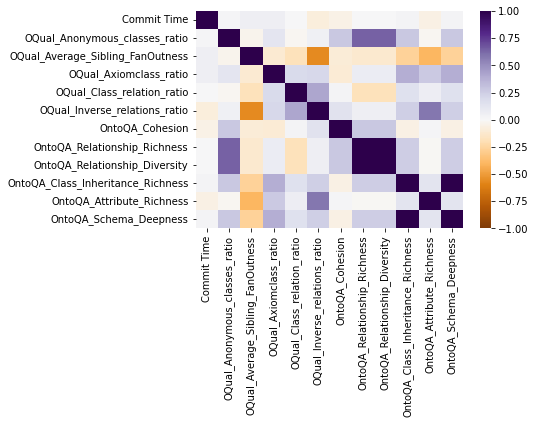

In [31]:
# Correlation Matrix Overall
def corrMatrix(selectedDF: pd.DataFrame):
    """Prints the Correleation Matrix. Needs the analyzedMetrics!

    Args:
        selectedDF (pd.DataFrame): Input Ontology Metrics

    Returns:
        pd.DataFrame: Correletion Matrix
    """
    dfDraw = pd.DataFrame()
    dfDraw["Commit Time"] = normalizeMetric(selectedDF, "CommitTime").astype(float)
    
    for elementName, displayName in metricsToBeAnalyzed.items():
        dfDraw[elementName] = normalizeMetric(selectedDF, elementName)
    # return dfDraw
    return dfDraw.corr(method="kendall")

sns.heatmap(data=corrMatrix(df), vmin=-1, vmax=1, cmap="PuOr")

# H1: Ontologies grow during their Lifetime

In [32]:
tmpdf = df.copy()
tmpdf = tmpdf.groupby("fileName")[["CommitTimeNormalized","axioms"]].corr(method="spearman").xs("CommitTimeNormalized", level=1)
print("Number of Ontologies with a spearman-correlation < 0.5: " + str(len(tmpdf[tmpdf.axioms<0.5]))+"/"+str(len(tmpdf)))
tmpdf = df.copy()
tmpdf = tmpdf.groupby("fileName")[["CommitTimeNormalized","axioms"]].corr(method="pearson").xs("CommitTimeNormalized", level=1)
print("Number of Ontologies with a pearson-correlation < 0.5: " + str(len(tmpdf[tmpdf.axioms<0.5]))+"/"+str(len(tmpdf)))

Number of Ontologies with a spearman-correlation < 0.5: 17/49
Number of Ontologies with a pearson-correlation < 0.5: 17/49


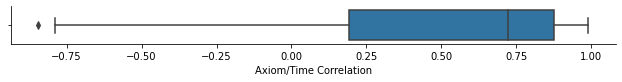

In [33]:
# Assumption 1: Ontologies grow during their lifetime
tmpdf = df.copy()

tmpdf = tmpdf.groupby("fileName")[["CommitTimeNormalized","axioms"]].corr(method="pearson").xs("CommitTimeNormalized", level=1)
plt = sns.catplot(data=tmpdf, x="axioms", height=1.25, aspect=7, kind="box")
plt.set_xlabels("Axiom/Time Correlation")
plt.savefig("axiomsCorrelation.svg")

In [22]:
## Check for the growth in axioms for the median of the first and second half of the analyzing period.
def analyzeGrowh(df: pd.DataFrame, toAnalyze: list, analyzeMedian:bool):
    tmpdf = df.copy()
    tmpdf["CommitTimeNormalized"]= normalizeMetric(df, "CommitTime")
    growthDF = pd.DataFrame()
    for element in toAnalyze:
        if (analyzeMedian):
            ontologyGrowth = tmpdf[tmpdf["CommitTimeNormalized"] >= 0.5].groupby("fileName").median()[element]  / tmpdf[tmpdf["CommitTimeNormalized"] < 0.5].groupby("fileName").median()[element]
        else:
            ontologyGrowth = tmpdf[tmpdf["CommitTimeNormalized"] == 1.0].set_index("fileName")[element]/ tmpdf[tmpdf["CommitTimeNormalized"] == 0.0].set_index("fileName")[element]
        calculation = {
            "metric": element,
            "analyzed": len(ontologyGrowth),
            "larger": len(ontologyGrowth[ontologyGrowth > 1])/ len(ontologyGrowth),
            "smaller": len(ontologyGrowth[ontologyGrowth < 1])/ len(ontologyGrowth),
            "same" : len(ontologyGrowth[ontologyGrowth == 1])/ len(ontologyGrowth),
            "nAn": len(ontologyGrowth[ontologyGrowth.isna()]) / len(ontologyGrowth)
        }
        if(len(growthDF) == 0):
            growthDF = pd.DataFrame([calculation])
        else:
            growthDF = pd.concat([growthDF, pd.DataFrame([calculation])])
    return growthDF

    
analyzeGrowh(df, metricsToBeAnalyzed.keys(), True)


,metric,analyzed,larger,smaller,same,nAn
0,OQual_Anonymous_classes_ratio,49,0.469,0.327,0.000,0.204
0,OQual_Average_Sibling_FanOutness,49,0.551,0.388,0.020,0.041
0,OQual_Axiomclass_ratio,49,0.510,0.490,0.000,0.000
0,OQual_Class_relation_ratio,49,0.286,0.429,0.000,0.286
0,OQual_Inverse_relations_ratio,49,0.102,0.367,0.041,0.490
0,OntoQA_Cohesion,49,0.327,0.163,0.510,0.000
0,OntoQA_Relationship_Richness,49,0.408,0.286,0.020,0.286
0,OntoQA_Relationship_Diversity,49,0.408,0.286,0.020,0.286
0,OntoQA_Class_Inheritance_Richness,49,0.490,0.510,0.000,0.000
0,OntoQA_Attribute_Richness,49,0.327,0.265,0.000,0.408


# H2: Ontology Change activity decreases over time

In [23]:
# Analyze Size of Changes
tmpdf = df.copy()
tmpdf.axioms = tmpdf.groupby("fileName")["axioms"].pct_change().abs()
bins = pd.cut(tmpdf["CommitTimeNormalized"], 3, labels=["1", "2", "3"])

tmpdf = pd.merge(left= tmpdf, right=bins, left_index=True, right_index=True)
tmpdf = tmpdf.rename({"CommitTimeNormalized_x": "CommitTimeNormalized",
        "CommitTimeNormalized_y": "time_binned"}, axis=1)

tmpdf = tmpdf.groupby(["fileName", "time_binned"]).mean()["axioms"].reset_index()

tmpdf = pd.pivot(tmpdf, columns=["time_binned"],index="fileName", values="axioms")
print(str(len(tmpdf[(tmpdf["1"] < tmpdf["3"]) | (tmpdf["2"] < tmpdf["3"])]))+ " of " + str(len(tmpdf)) + " ontologies have more mean change than in the last third of their life than in the rest")
print(str(len(tmpdf[(tmpdf["1"] > tmpdf["2"]) | (tmpdf["2"] < tmpdf["1"])]))+ " of " + str(len(tmpdf)) + " ontologies have the most mean change in the first third")


# Analyze number of Versions
tmpdf = df.copy()
tmpdf.axioms = tmpdf.groupby("fileName")["axioms"].pct_change().abs()
bins = pd.cut(tmpdf["CommitTimeNormalized"], 3, labels=["1", "2", "3"])
tmpdf = pd.merge(left= tmpdf, right=bins, left_index=True, right_index=True)
tmpdf = tmpdf.rename({"CommitTimeNormalized_x": "CommitTimeNormalized",
        "CommitTimeNormalized_y": "time_binned"}, axis=1)
tmpdf = tmpdf.groupby(["fileName", "time_binned"]).count()["axioms"].reset_index()
tmpdf = pd.pivot(tmpdf, columns=["time_binned"],index="fileName", values="axioms")
print(str(len(tmpdf[(tmpdf["1"] < tmpdf["3"]) | (tmpdf["2"] < tmpdf["3"])]))+ " of " + str(len(tmpdf)) + " ontologies have more changes than in the last third of their life than in the rest")
print(str(len(tmpdf[(tmpdf["1"] > tmpdf["2"]) | (tmpdf["2"] < tmpdf["1"])]))+ " of " + str(len(tmpdf)) + " ontologies have most changes in the first third")


33 of 49 ontologies have more mean change than in the last third of their life than in the rest
38 of 49 ontologies have the most mean change in the first third
24 of 49 ontologies have more changes than in the last third of their life than in the rest
41 of 49 ontologies have most changes in the first third


In [12]:
# Analyze how many commits were pushed at which point of the ontology lifetime



tmpdf = df.copy()
tmpdf.axioms = tmpdf.groupby("fileName")["axioms"].pct_change().abs()
tmpdf = binOntologies(tmpdf, minNumberOfVersions, True)
tmpdf = tmpdf[(tmpdf.axioms != 0) &( tmpdf.axioms != np.inf) & (tmpdf.axioms != -np.inf)]

g = sns.JointGrid(data=tmpdf, x="CommitTimeNormalized", y="axioms", height=8, ratio=4)
# g.plot_joint(sns.histplot)#, log_scal=(False, True))
g.plot_joint(sns.histplot, log_scale=(False, True), bins=minNumberOfVersions)
g.plot_marginals(sns.violinplot, cut=0, color="lightgrey", scale="area")
g.set_axis_labels(xlabel="Ontology Lifetime", ylabel="% Axiom Change")
# g.plot_marginals(sns.boxplot)
g.savefig("changeActivity.svg")

tmpdf.groupby("fileName").axioms.count()
# sns.relplot(data=tmpdf, x="CommitTimeNormalized",  y="axioms", hue="bins", height = 5, aspect=4)


fileName
github.com/AgriculturalSemantics/agro/src/ontology/agro-edit.owl                                                                       40
github.com/DiseaseOntology/HumanDiseaseOntology/src/ontology/imports/uberon_import.owl                                                 40
github.com/EBISPOT/efo/src/ontology/efo-3-edit.owl                                                                                     40
github.com/FellowsFreiesWissen/Ogham/owl/ogham.owl                                                                                     33
github.com/FoodOntology/foodon/imports/langual_import.owl                                                                              31
github.com/HerculesCRUE/ib-hercules-ontology/src/asio-core.ttl                                                                         36
github.com/ICCD-MiBACT/ArCo/ArCo-release/ontologie/arco/arco.owl                                                                       32
github.com/ICCD-MiBACT/Ar

Error in callback <function flush_figures at 0x000001F15525D5E0> (for post_execute):


KeyboardInterrupt: 

# H3: The Instances are Introduced after the Initial Design

In [15]:
tmpdf = df.copy()
print("Ontologies that do not have individuals:")
individualsInOntologies = (tmpdf.groupby("fileName").max()["individuals"] == 0)
individualsInOntologies.value_counts()


Ontologies that do not have individuals:


False    69
True     65
Name: individuals, dtype: int64

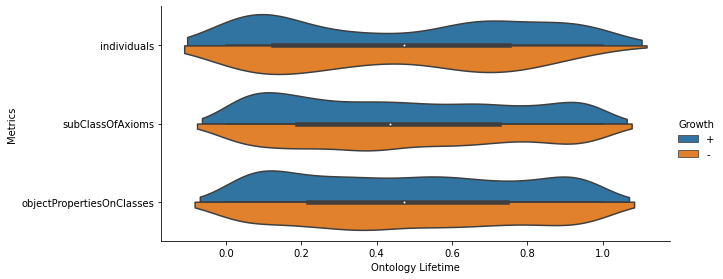

In [16]:
tmpdf = df.copy()

tmpdf = binOntologies(df, minNumberOfVersions, True)

tmpdf.time_binned = tmpdf.time_binned.astype(float)
individualsInOntologies = individualsInOntologies[individualsInOntologies==False]
tmpdf[tmpdf.fileName.isin(individualsInOntologies.index)]
tmpdf.individuals = tmpdf.groupby("fileName")["individuals"].pct_change()
tmpdf.subClassOfAxioms = tmpdf.groupby("fileName")["subClassOfAxioms"].pct_change()
tmpdf.objectPropertiesOnClasses = tmpdf.groupby("fileName")["objectPropertiesOnClasses"].pct_change()
tmpdf = tmpdf.melt(value_vars=["individuals", "subClassOfAxioms", "objectPropertiesOnClasses"], id_vars=["time_binned", "fileName"])

tmpdf = tmpdf.dropna()
tmpdf = tmpdf[(tmpdf.value != 0) & ( tmpdf.value != np.inf) & (tmpdf.value != -np.inf)]
tmpdf = tmpdf.assign(Growth=tmpdf.value.map(lambda x: "+" if x > 0 else "-"))
g = sns.catplot(data=tmpdf, x="time_binned", y="variable", cut=1, kind="violin", height= 4, aspect=2.4, scale="area", hue="Growth", split=True)
g.set_xlabels("Ontology Lifetime")
g.set_ylabels("Metrics")
g.savefig("individuals vs Axioms.svg")

# H4: Ontologies are getting more complex with increasing maturity 

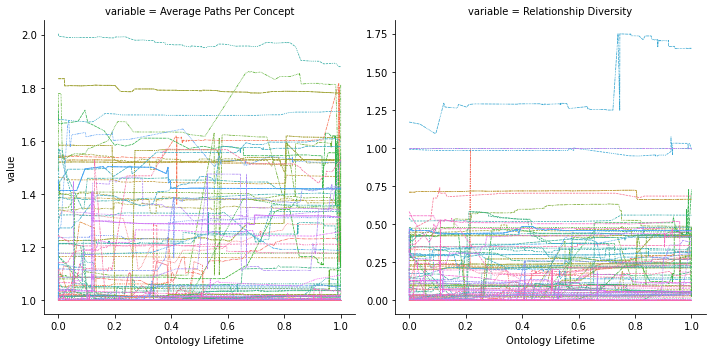

In [17]:
tmpdf = df.copy()
tmpdf.OntoQA_Relationship_Diversity = tmpdf.OntoQA_Relationship_Diversity.fillna(0)
tmpdf = tmpdf[["fileName", "CommitTimeNormalized", "OntoQA_Relationship_Diversity", "ComplexityMetrics_Average_Paths_Per_Concept"]]
# dfDraw = tmpdf.groupby("fileName").corr(method="pearson")
filesWithoutChange = tmpdf.groupby("fileName").apply(lambda x: x.OntoQA_Relationship_Diversity.min() == x.OntoQA_Relationship_Diversity.max() or x.ComplexityMetrics_Average_Paths_Per_Concept.min() == x.ComplexityMetrics_Average_Paths_Per_Concept.max())
dfDraw = tmpdf[tmpdf.fileName.isin(filesWithoutChange[filesWithoutChange == False].index)].groupby("fileName").corr(method="pearson")


# tmpdf = binOntologies(tmpdf, minNumberOfVersions, False)
# Normally, this value cannot be below 1. In some rare instances, if the ontology states explicitly that a class is
# a subclass of owl:thing, and elsewhere structured as a tree, we get a false count of below 1. The reason is that this increases the subclass-count,
# but the path count does not regard owl:thing relationcounts. For these cases, we clip the values to 1, as these things just happens in flat, tree like structures.
tmpdf.ComplexityMetrics_Average_Paths_Per_Concept = tmpdf.ComplexityMetrics_Average_Paths_Per_Concept.clip(lower=1)
tmpdf = tmpdf.melt(id_vars = ["fileName", "CommitTimeNormalized"], value_vars=["ComplexityMetrics_Average_Paths_Per_Concept", "OntoQA_Relationship_Diversity"])
tmpdf.variable = tmpdf.variable.replace({"ComplexityMetrics_Average_Paths_Per_Concept": "Average Paths Per Concept", "OntoQA_Relationship_Diversity": "Relationship Diversity"})

g = sns.relplot(kind="line", data=tmpdf, x="CommitTimeNormalized", y="value", hue="fileName", style="fileName", size=0.001, legend=False, col="variable", facet_kws=dict(sharey=False))
g.set_xlabels("Ontology Lifetime")
g.savefig("OntologyComplexity.svg")





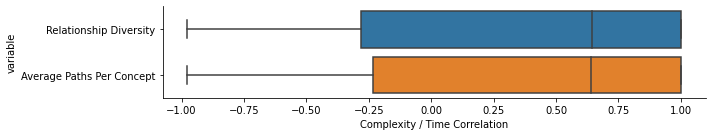

In [27]:
# Correlation
tmpdf = dfDraw.reset_index().melt(id_vars="fileName", value_vars=["OntoQA_Relationship_Diversity", "ComplexityMetrics_Average_Paths_Per_Concept"])
tmpdf.variable = tmpdf.variable.replace({"ComplexityMetrics_Average_Paths_Per_Concept": "Average Paths Per Concept", "OntoQA_Relationship_Diversity": "Relationship Diversity"})
g = sns.catplot(data=tmpdf, kind="box", x="value", y="variable",   height= 2, aspect=5)
g.set_xlabels("Complexity / Time Correlation")
g.savefig("complexityTimeBoxplot.svg")

In [28]:
# Prepare the dataset for ML


def prepareDataSet(df, timeBinned=True, setNanToZero=False):
    tmpdf = df.copy()
    tmpdf["weight"] = tmpdf["fileName"].map(1/tmpdf.groupby("fileName")["axioms"].count())
    
    if(timeBinned):
        # The different count of versions can have an influence on the ML-algorithms. THe binning for time reduces the number of 
        # input versions to a fixed number, thus all ontologies have the versions going into the learning enginge and bias is prevented.
        bins = pd.cut(tmpdf["CommitTimeNormalized"], minNumberOfVersions)
        bins = bins.map(lambda x: x.mid)
        tmpdf = pd.merge(left= tmpdf, right=bins, left_index=True, right_index=True)
        tmpdf = tmpdf.rename({"CommitTimeNormalized_x": "CommitTimeNormalized",
        "CommitTimeNormalized_y": "time_binned"}, axis=1)
    if(setNanToZero):
        for element in metricsToBeAnalyzedList:
            tmpdf[element] = tmpdf[element].fillna(0)
    # Bin ontology size
    bins = pd.cut(tmpdf.groupby("fileName")["axioms"].mean(), bins=[0, 500, 2000, 5000, 50000, 200000000])

    tmpdf = pd.merge(left= tmpdf, right=bins, left_on="fileName", right_index=True)
    tmpdf = tmpdf.rename({
    "axioms_x" : "axioms", 
    "axioms_y" : "size_category"}, axis=1)

    if(timeBinned):
        tmpdf = tmpdf.groupby(by=["size_category", "repository", "fileName", "weight", "time_binned"], dropna=False, observed = True, as_index=False).mean()
        tmpdf.CommitTimeNormalized = tmpdf.time_binned.astype("float")
    return tmpdf

Explained Variance by PCs


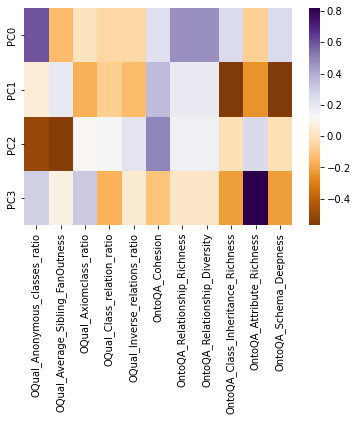

In [29]:
def appendPCA(numberOfPCs, df: pd.DataFrame, drawVariancePlot=False)->pd.DataFrame:
    from sklearn.decomposition import PCA
    from sklearn.compose import ColumnTransformer
    import matplotlib as plt
    
    tmpdf = df.copy()

    for element in metricsToBeAnalyzed:
        tmpdf = tmpdf.assign(**{element: normalizeMetric(tmpdf, element)})
    metricsToAnalyze = [metric for metric in metricsToBeAnalyzed.keys()]
    tmpdf = tmpdf[metricsToAnalyze]
    tmpdf = tmpdf.dropna()

    tmpdf["oldIndex"] = tmpdf.index
    featurizer = ColumnTransformer(transformers=[("pca", PCA(numberOfPCs), metricsToAnalyze)],remainder='passthrough')
    fit = featurizer.fit(X=tmpdf)
    
    
    variance = featurizer.named_transformers_["pca"]
    global varianceRatio 
    varianceRatio = variance.explained_variance_ratio_
    global pcNames
    pcNames = ["PC"+ str(x) for x in range(numberOfPCs)]
    if(drawVariancePlot):
        print("Explained Variance by PCs")
        # sns.lineplot(y=varianceRatio.cumsum(), )
        # sns.set(rc={"figure.figsize": (20, 8)})
        
        sns.heatmap(data=pd.DataFrame(variance.components_), cmap="PuOr",xticklabels=metricsToAnalyze, yticklabels=pcNames)
        
        
        


    dfDraw = pd.DataFrame(featurizer.transform(X=tmpdf)).copy()
    dfDraw = dfDraw.rename(columns=lambda x: "PC" + str(x) if int(x) < len(dfDraw.columns)-1 else "index")
    dfDraw = dfDraw.set_index("index", drop=True)
        
    dfDraw= df.join(dfDraw, )
    # dfDraw = dfDraw.set_index("index")
    return dfDraw
ratio = appendPCA(4, df, True)


[0.45924331 0.71619087 0.81169331 0.88323799]


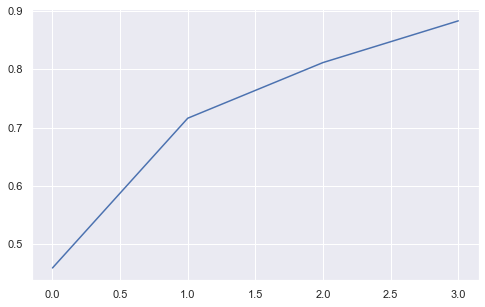

In [30]:
sns.set(rc={"figure.figsize": (8, 5)})
sns.lineplot(x=[(i) for i in range(len(varianceRatio.cumsum()))], y=varianceRatio.cumsum())
print(varianceRatio.cumsum())

In [31]:
def appendKMeansCluster(df, numberOfClusters, metricsToBeAnalyzedInput: list, normalize: bool, showVarianceDistribution=False):
    from sklearn.cluster import KMeans
    import kneed
    tmpdf = df.copy()
    metricsToBeAnalyzed = metricsToBeAnalyzedInput
    
    # as we're taking the PCA as an input, a second normalization for the clustering is not necessary.
    if(normalize):
        for element in metricsToBeAnalyzed:
            tmpdf = tmpdf.assign(**{element: normalizeMetric(tmpdf, element)})
    
    if("CommitTimeNormalized" in tmpdf):
        tmpdf = tmpdf[tmpdf.CommitTimeNormalized.isin( tmpdf.groupby("fileName").CommitTimeNormalized.max())]
        # tmpdf = tmpdf.drop("weight", axis=1)
        
    tmpdf = tmpdf.dropna(subset=metricsToBeAnalyzed)
    
    if(showVarianceDistribution):
        distorsions = {}
        for k in range(2, 20):
            kmeans = KMeans(n_clusters=k, max_iter=3000)
            if "weight" in tmpdf:
                # kmeans.fit(tmpdf[metricsToBeAnalyzed])#, sample_weight=tmpdf.weight)
                kmeans.fit(tmpdf[metricsToBeAnalyzed], sample_weight=tmpdf.weight)
            else:
                kmeans.fit(tmpdf[metricsToBeAnalyzed])
            distorsions[k] = kmeans.inertia_
        knee= kneed.KneeLocator(x=list(distorsions.keys()), y=list(distorsions.values()),curve="convex", direction="decreasing")
        knee.plot_knee()
        print("kneepoint for KMEANS: " + str(knee.knee))
    
    cluster = KMeans(numberOfClusters)

    # The more a PC explains, the bigger should its weight be.
    if "PC" in metricsToBeAnalyzedList:
        for i in range(0, len(metricsToBeAnalyzedList)):
            tmpdf["PC" + str(i)].weight = tmpdf["PC" + str(i)].weight * varianceRatio[i]

    if "weight" in tmpdf:
        tmpdf["cluster"] = cluster.fit_predict(tmpdf[metricsToBeAnalyzed], sample_weight=tmpdf.weight)
    else:
        tmpdf["cluster"] = cluster.fit_predict(tmpdf[metricsToBeAnalyzed])
    # We still just got the latest version, first retrieve the filenames agagin
    tmpdf = pd.merge(left=tmpdf, right=df, left_index=True, right_index=True)
    tmpdf = tmpdf[["cluster", "fileName_x"]]
    # Selects the most prominent cluster per filename.
    tmpSeries = tmpdf.groupby(["fileName_x"])["cluster"].max()
    df["cluster"] = df["fileName"].map(tmpSeries, na_action="ignore")  
    return df["cluster"]


In [41]:
def findIdealNumberOfClusters(df:pd.DataFrame, analyzeUpTo:int)->pd.DataFrame:
    """Runs the KMeans and Birch clustering Method up to the given number of Clusters. Analyzes the clustering performance with the Silhuette method
        Takes the pcNames as the kind of analyzed input parameters.

        Args:
            df (pd.DataFrame): Analyzable DataFrame
            analyzeUpTo (int): Number from 2 to the given value for the number of clusters

        Returns:
            pd.DataFrame: Dataframe containing the performance of the number of clusters and the clustering methodolgies.
    """
    
    dfPrepared = df.copy()
    clustera = {}
    clusterb = {}
    for numberOfClusters in range(4, analyzeUpTo):
        dfPrepared["cluster"] = appendKMeansCluster(df=df.copy(), metricsToBeAnalyzedInput=pcNames, numberOfClusters=numberOfClusters, normalize=False, showVarianceDistribution=False)
        clustera.update({str(numberOfClusters): metrics.silhouette_score(X=dfPrepared[pcNames], labels=dfPrepared["cluster"]) if dfPrepared.cluster.nunique() > 1 else -1})
    return(pd.DataFrame({"kmeans":clustera}))

Please be aware that the KMeans algorithm is based on testing random distributions for reducing variance along clusters. In effect, re-running the clustering algorithm will result in a slightly different outcome than in the paper!

          10    11    12    13    14    15    16    17    18    19     4  \
kmeans 0.270 0.297 0.253 0.315 0.245 0.291 0.287 0.354 0.409 0.400 0.264   

           5     6     7     8     9  
kmeans 0.245 0.302 0.314 0.326 0.309  
kneepoint for KMEANS: 6


,name,clusters,silhouette,Davies Bouldin,commits,files,meanOntologySize,min Vesions,max Versions,max Axioms,min Axioms,mean Axioms
cluster,,,,,,,,,,,,
0,Kmeans,5,0.347,1.025,1792,24,74.667,43,356,12973.000,3.000,1688.907
1,Kmeans,5,0.347,1.025,1359,7,194.143,51,660,13706.000,19.000,3803.869
2,Kmeans,5,0.347,1.025,984,13,75.692,40,172,33207.000,29.000,5652.734
3,Kmeans,5,0.347,1.025,578,4,144.500,41,356,13706.000,8.000,6605.564
4,Kmeans,5,0.347,1.025,51,1,51.000,51,51,180.000,135.000,158.882


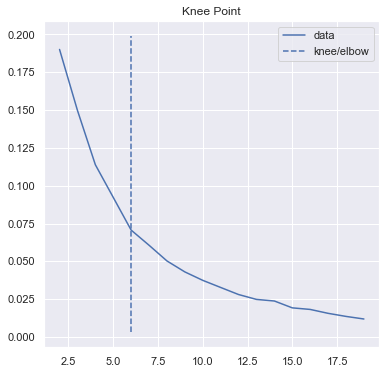

In [63]:
# Test the Clustering Methods

# tmpSeries = dfPrepared.groupby("fileName")["axioms"].min()
# dfPrepared = dfPrepared[dfPrepared.fileName.isin(tmpSeries[tmpSeries > 100].index)]
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import kneed
from sklearn import preprocessing

# Apply KMEANS Clustering
dfPrepared = df.copy()

if "axioms" in metricsToBeAnalyzedList:
    metricsToBeAnalyzedList.remove("axioms")
    metricsToBeAnalyzedList.remove("classes")
pcNames = metricsToBeAnalyzedList
dfPrepared = appendPCA(4, df, False).copy()
dfPrepared = prepareDataSet(dfPrepared, timeBinned=False, setNanToZero=True)

dfPrepared = dfPrepared.dropna(subset=pcNames)

# for element in pcNames:
    # dfPrepared = dfPrepared.assign(**{element: normalizeMetric(dfPrepared, element)})
    # pass
print(findIdealNumberOfClusters(dfPrepared, 20).transpose())
dfPrepared["cluster"] = appendKMeansCluster(df=dfPrepared.copy(), metricsToBeAnalyzedInput=pcNames, numberOfClusters=5, normalize=False, showVarianceDistribution=True)
if dfPrepared.cluster.nunique() <2:
    raise Exception("No Cluster detected!") 
clusterEvaluation = pd.DataFrame.from_dict(

    {
        "name": "Kmeans",
        "clusters": dfPrepared["cluster"].value_counts().count(),
        "silhouette": metrics.silhouette_score(X=dfPrepared[pcNames], labels=dfPrepared["cluster"]),
        "Davies Bouldin": metrics.davies_bouldin_score(X=dfPrepared[pcNames], labels=dfPrepared["cluster"]),
        "commits":dfPrepared.groupby("cluster")["fileName"].count(), 
        "files":dfPrepared.groupby("cluster")["fileName"].nunique(),
        "meanOntologySize": dfPrepared.groupby("cluster")["fileName"].count() / dfPrepared.groupby("cluster")["fileName"].nunique(),
        "min Vesions":dfPrepared.groupby("cluster")["fileName"].value_counts().droplevel(1).groupby("cluster").min(),
        "max Versions":dfPrepared.groupby("cluster")["fileName"].value_counts().droplevel(1).groupby("cluster").max(),
        "max Axioms":dfPrepared.groupby("cluster")[["fileName", "classes"]].max().classes,
        "min Axioms":dfPrepared.groupby("cluster")[["fileName", "classes"]].min().classes,
        "mean Axioms":dfPrepared.groupby("cluster")[["fileName", "classes"]].mean().classes
        
 })


# dfPrepared["correlation_binned"] = pd.cut(x=dfPrepared["correlation"], bins = [-1,-0.25, 0.25,1], labels=["Negative", "None", "Positive"])
# tmpdf = dfPrepared.groupby(["cluster", "repository"])["fileName"].count()
clusterEvaluation


In [64]:
tmpdf = dfPrepared.groupby(["cluster", "repository"])["fileName"].aggregate([pd.Series.nunique, pd.Series.count])
# tmpdf = dfPrepared.groupby(["cluster"])["axioms"].aggregate([pd.Series.nunique, pd.Series.count, pd.Series.mean])
tmpdf

nunique  count
cluster repository                                                        
0       github.com/DiseaseOntology/HumanDiseaseOntology           1     83
        github.com/FellowsFreiesWissen/Ogham                      1     43
        github.com/FoodOntology/foodon                            1     56
        github.com/HerculesCRUE/ib-hercules-ontology              1     54
        github.com/ICCD-MiBACT/ArCo                               1     73
        github.com/OpenSILEX/ontology-vocabularies                1     59
        github.com/PHI-base/phi-eco                               1     51
        github.com/PopulationAndCommunityOntology/pco             2    101
        github.com/SpeciesFileGroup/nomen                         1     66
        github.com/bio-ontology-research-group/unit-ont...        3    153
        github.com/jannahastings/mental-functioning-ont...        1     49
        github.com/microbialphenotypes/OMP-ontology               1     64
        github.com/obi-ontology/obi-legacy-svn                    3    342
        github.com/pombase/fypo                                   1    356
        github.com/ukparliament/ontologies                        3    140
        github.com/w3c-lbd-cg/bot                                 1     48
        github.com/weso/hercules-ontology                         1     54
1       github.com/ICCD-MiBACT/ArCo                               2    148
        github.com/OMIABIS/omiabis-dev                            1     78
        github.com/RDFBones/RDFBones-O                            1     51
        github.com/bio-ontology-research-group/unit-ont...        1     66
        github.com/obi-ontology/obi-legacy-svn                    1    660
        github.com/pombase/fypo                                   1    356
2       github.com/AgriculturalSemantics/agro                     1    172
        github.com/EBISPOT/efo                                    1    162
        github.com/ICCD-MiBACT/ArCo                               2    114
        github.com/bio-ontology-research-group/unit-ont...        1     55
        github.com/ease-crc/soma                                  1     42
        github.com/oeg-upm/delta-ontology                         1     56
        github.com/tetherless-world/ontology-engineering          5    334
        github.com/tetherless-world/study-cohort-ontology         1     49
3       github.com/ICCD-MiBACT/ArCo                               1    119
        github.com/RDFBones/FrSexEst                              1     41
        github.com/iot-ontologies/dogont                          1     62
        github.com/pombase/fypo                                   1    356
4       github.com/bio-ontology-research-group/unit-ont...        1     51

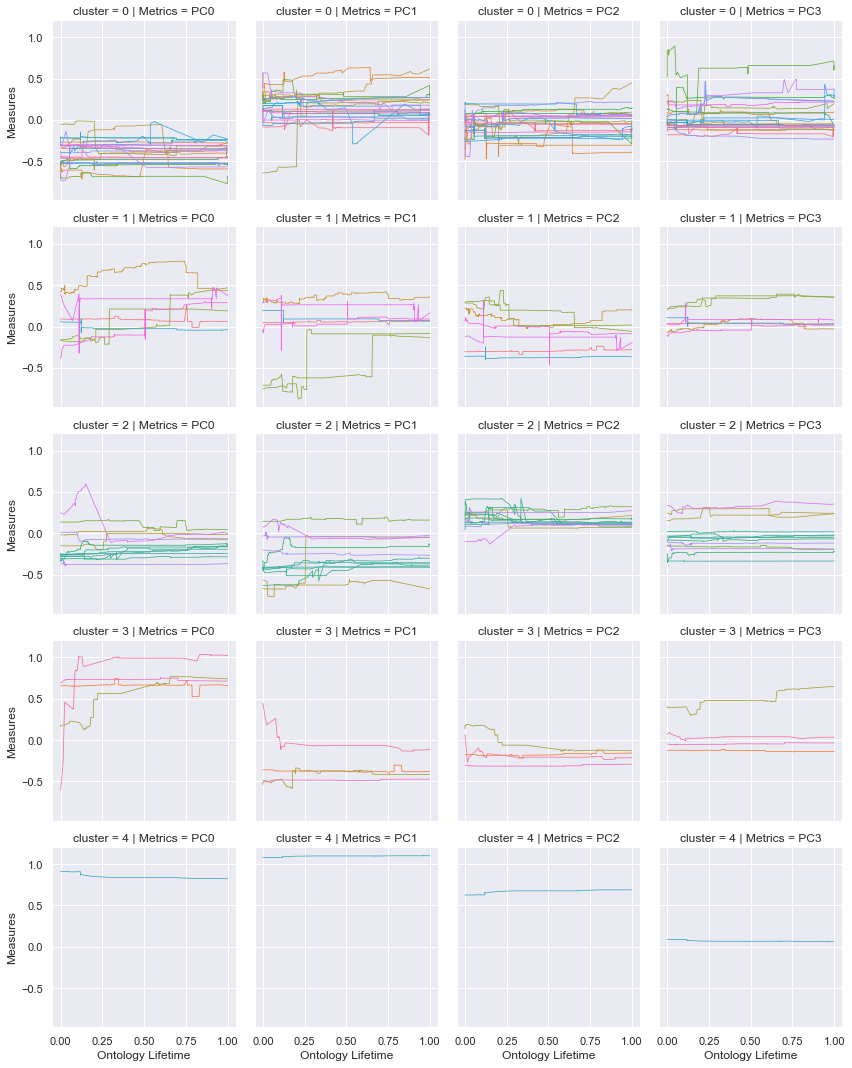

In [65]:
# Print the PCs along the time and Clusters
tmpdf = dfPrepared.copy()
# for element in pcNames:
#     tmpdf[element] = tmpdf[element].clip(lower=-1, upper=1)

tmpdf = tmpdf.melt(id_vars=["CommitTimeNormalized", "cluster", "size_category", "fileName", "weight"], value_name="Measures",var_name="Metrics", value_vars=pcNames )
g= sns.relplot(data=tmpdf, x="CommitTimeNormalized", y="Measures", row="cluster", col="Metrics", hue="fileName", kind="line", size = 0.001, legend=False, height=3)#, facet_kws=dict(sharey=False))
g.set_xlabels("Ontology Lifetime")
g.savefig("pcaClustering.svg")
